This example shows how to use adversarial attacks to fool a custom classifier trained on the MNIST dataset using the `AdvSecureNet` library.

# Setup

In [1]:
# import libraries
from advsecurenet.models.model_factory import ModelFactory
from advsecurenet.datasets import DatasetFactory
from advsecurenet.dataloader import DataLoaderFactory
from advsecurenet.attacks import PGD, CWAttack, FGSM, LOTS, DeepFool
from advsecurenet.shared.types import DatasetType, ModelType, AttackConfigs
from advsecurenet.utils.model_utils import load_model, download_weights
import matplotlib.pyplot as plt
import torch

/Users/melih/.pyenv/versions/3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_img_label(loader, index):
    # select one image from the test dataset
    image, label = next(iter(loader))
    # add a batch dimension
    image = image[index].unsqueeze(0)
    label = label[index].unsqueeze(0)
    return image, label

In [3]:
def visualize_adversarial_attack(image, label, model, adversarial_image):
    perturbation = adversarial_image - image
    
    def plot_image(tensor, title, channel_color='gray'):
        tensor = tensor.squeeze()  # Remove all singleton dimensions
        
        # Check if tensor is RGB or grayscale
        if len(tensor.shape) == 3 and tensor.shape[0] == 3:  # RGB Image
            tensor = tensor.permute(1, 2, 0)
        else:  # Grayscale Image
            channel_color = 'gray'

        plt.imshow(tensor.numpy(), cmap=channel_color)
        plt.title(title)

    plt.figure(figsize=(10,10))

    # Original Image
    plt.subplot(1, 3, 1)
    plot_image(image, "Original Image")
    plt.xlabel("Label: {}".format(label.item()))

    # Perturbation
    plt.subplot(1, 3, 2)
    plot_image(perturbation, "Perturbation")

    # Adversarial Image
    plt.subplot(1, 3, 3)
    plot_image(adversarial_image, "Adversarial Image")
    plt.xlabel("Label: {}".format(model(adversarial_image).argmax().item()))

    plt.show()


# MNIST - Custom Classifier

In [4]:
# first  download the weights
download_weights(filename="CustomMnistModel_mnist_weights.pth")

Weights already exist at /Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/weights/CustomMnistModel_mnist_weights.pth


'/Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/weights/CustomMnistModel_mnist_weights.pth'

In [5]:

# get the model
model = ModelFactory.get_model('CustomMnistModel', num_classes=10, num_channels=1) # this assumes that the CustomMnistModel is defined in the models/CustomMnistModel.py file
model = load_model(model, 'CustomMnistModel_mnist_weights.pth')
model.eval()

 custom_module_name  advsecurenet.models.CustomModels.CustomMnistModel


CustomModel(
  (model): CustomMnistModel(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=50176, out_features=512, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [6]:
# get the dataset
datasetObj =DatasetFactory.load_dataset(DatasetType.MNIST)
trainData = datasetObj.load_dataset(train=True)
testData = datasetObj.load_dataset(train=False)

In [7]:
# get the dataloader
trainDataLoader = DataLoaderFactory.get_dataloader(trainData,batch_size=32, shuffle=True)
testDataLoader = DataLoaderFactory.get_dataloader(testData,batch_size=32, shuffle=False)


In [8]:
image, label = get_img_label(testDataLoader, 4) # get the 4th image from the test dataset

## Carlini&Wagner attack

### Untargetted

In [9]:
# generate the adversarial image using untargeted CW attack
cw_config = AttackConfigs.CWAttackConfig(
    targeted=False,
    learning_rate=0.1,
    max_iterations=100,
    c_init=1e-5,
    binary_search_steps=15,
    c_upper=1e2,
)
cw = CWAttack(cw_config)
adversarial_image = cw.attack(model, image, label)

Binary Search Steps: 100%|██████████| 15/15 [00:39<00:00,  2.62s/it]


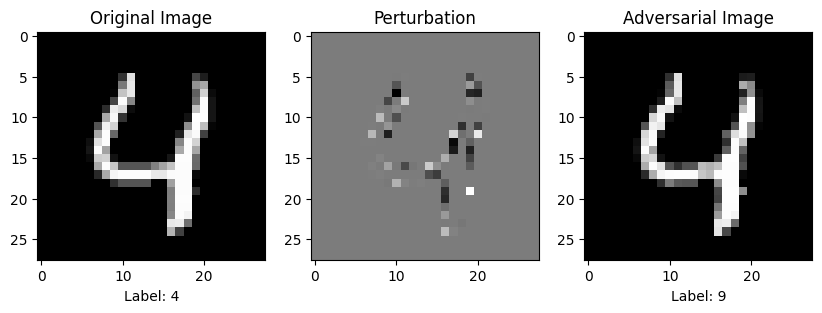

In [10]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)


### Targetted

In [11]:
# generate the adversarial image using untargeted CW attack
cw_config = AttackConfigs.CWAttackConfig(
    targeted=True,
    learning_rate=0.1,
    max_iterations=100,
    c_init=1e-5,
    binary_search_steps=15,
    c_upper=1e2,
)
cw = CWAttack(cw_config)
target = torch.tensor([1])
adversarial_image = cw.attack(model, image, target)

Binary Search Steps: 100%|██████████| 15/15 [00:39<00:00,  2.63s/it]


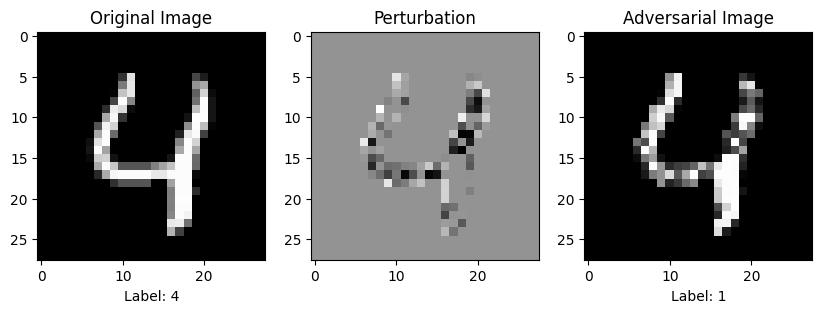

In [12]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## DeepFool attack

In [13]:
# generate the adversarial image using deepfool attack
df_config = AttackConfigs.DeepFoolAttackConfig()
df = DeepFool(df_config)
adversarial_image = df.attack(model, image, label)

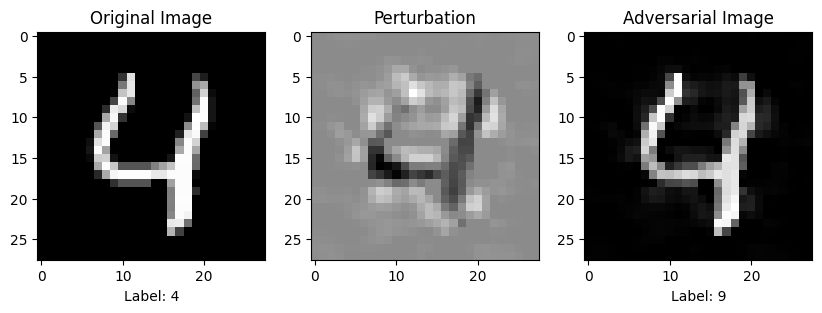

In [14]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## FGSM attack

In [15]:
# generate the adversarial image using FGSM attack
fgsm_config = AttackConfigs.FgsmAttackConfig(
    epsilon=0.05
)
fgsm = FGSM(fgsm_config)
adversarial_image = fgsm.attack(model, image, label)

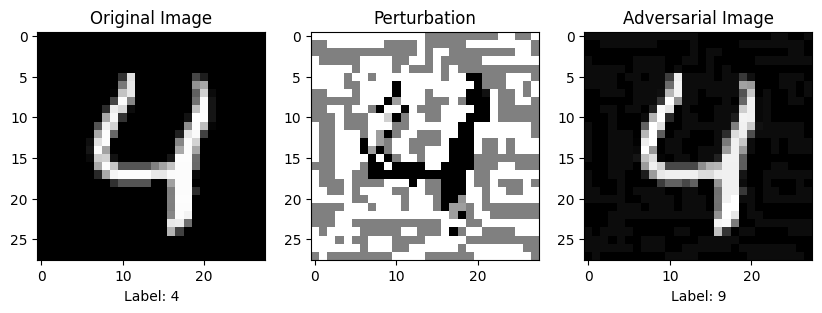

In [16]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## LOTS attack

### Iterative LOTS attack

In [17]:
# generate the adversarial image using PGD attack
target_layer = "model.fc2" # this is the name of the layer that we want to target - this assumes that the model has a layer named fc2
lots_config = AttackConfigs.LotsAttackConfig(
    deep_feature_layer=target_layer,
    mode = AttackConfigs.LotsAttackMode.ITERATIVE,
    max_iterations=100,
    learning_rate=0.01,
    epsilon=0.1,
)
lots = LOTS(lots_config)

target_img, target_label = get_img_label(testDataLoader, 10) # get the 5th image from the test dataset
print("Actual label: {}".format(label.item()), " Target label: {}".format(target_label.item()))

adv_img, is_found = lots.attack(model, image, target_img, target_label)
print("Is the adversarial image found: {}".format(is_found))

Actual label: 4  Target label: 0


                                                              0 [00:00<00:04, 18.38it/s]

Is the adversarial image found: True


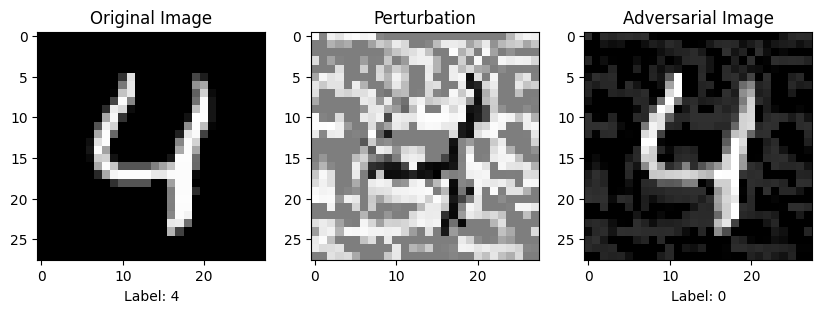

In [18]:
# plot the images
visualize_adversarial_attack(image, label, model, adv_img)

### Single-step LOTS attack

In [19]:
target_layer = "model.fc2" # this is the name of the layer that we want to target - this assumes that the model has a layer named fc2

lots_config = AttackConfigs.LotsAttackConfig(
    deep_feature_layer=target_layer,
    mode = AttackConfigs.LotsAttackMode.ITERATIVE,
    max_iterations=100,
    learning_rate=0.1,
    epsilon=0.5,
)
lots = LOTS(lots_config)

target_img, target_label = get_img_label(testDataLoader, 10) # get the 10th image from the test dataset
print("Actual label: {}".format(label.item()), " Target label: {}".format(target_label.item()))

adv_img, is_found = lots.attack(model, image, target_img, target_label)
print("Is the adversarial image found: {}".format(is_found))

Actual label: 4  Target label: 0


                                                             0 [00:00<00:06, 15.71it/s]

Is the adversarial image found: True


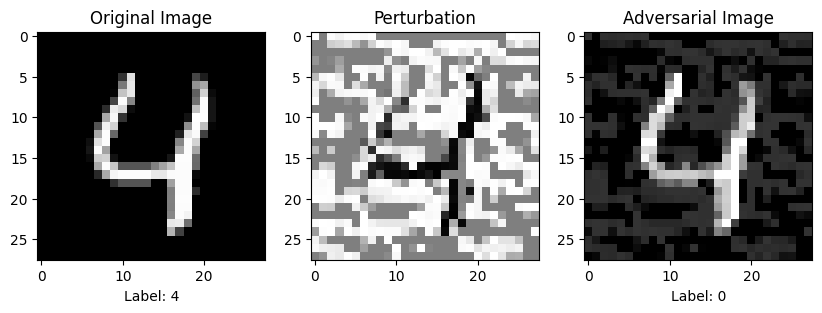

In [20]:
# plot the images
visualize_adversarial_attack(image, label, model, adv_img)

## PGD attack

In [21]:
# generate the adversarial image using PGD attack

pgd_config = AttackConfigs.PgdAttackConfig(epsilon=0.05)
pgd = PGD(pgd_config)
adversarial_image = pgd.attack(model, image, label)

PGD Iterations: 100%|██████████| 40/40 [00:01<00:00, 38.10it/s]


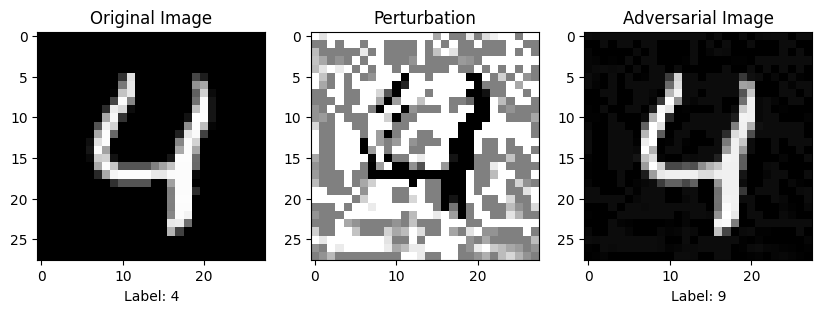

In [22]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

# Cifar10 - ResNet18

This part of the notebook shows how to use adversarial attacks to fool a known classifier trained on the CIFAR10 dataset using the `AdvSecureNet` library.

In [23]:
# first download the weights
download_weights(filename="resnet18_cifar10_weights.pth")

Weights already exist at /Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/weights/resnet18_cifar10_weights.pth


'/Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/weights/resnet18_cifar10_weights.pth'

In [24]:
# get the model
model = ModelFactory.get_model('resnet18', num_classes=10, num_channels=3)
model = load_model(model, 'resnet18_cifar10_weights.pth')
model.eval()


StandardModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [25]:
# get the dataset
datasetObj =DatasetFactory.load_dataset(DatasetType.CIFAR10)
trainData = datasetObj.load_dataset(train=True)
testData = datasetObj.load_dataset(train=False)

100%|██████████| 170498071/170498071 [02:09<00:00, 1320387.95it/s]


Extracting /Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/data/cifar-10-python.tar.gz to /Users/melih/Desktop/master tezi/spe/advsecurenet/advsecurenet/data
Files already downloaded and verified


In [26]:
# get the dataloader
trainDataLoader = DataLoaderFactory.get_dataloader(trainData,batch_size=32, shuffle=True)
testDataLoader = DataLoaderFactory.get_dataloader(testData,batch_size=32, shuffle=False)


In [27]:
image, label = get_img_label(testDataLoader, 4) # get the 4th image from the test dataset

## Carlini&Wagner attack

### Untargetted

In [28]:
# generate the adversarial image using untargeted CW attack
cw_config = AttackConfigs.CWAttackConfig(
    targeted=False,
    learning_rate=0.1,
    max_iterations=100,
    c_init=1e-5,
    binary_search_steps=15,
    c_upper=1e2,
)
cw = CWAttack(cw_config)
adversarial_image = cw.attack(model, image, label)

Binary Search Steps: 100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


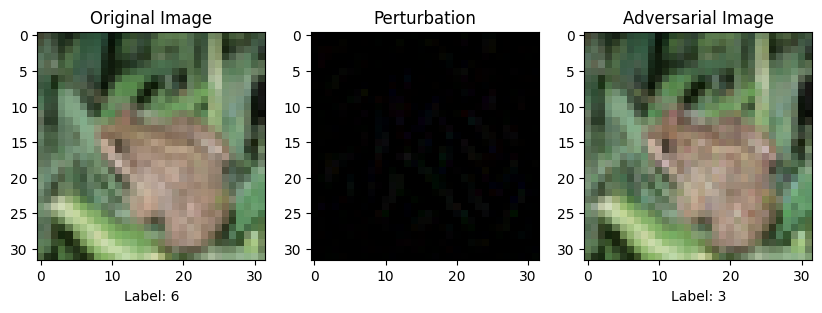

In [29]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

### Targetted

In [30]:
# generate the adversarial image using untargeted CW attack
cw_config = AttackConfigs.CWAttackConfig(
    targeted=True,
    learning_rate=0.1,
    max_iterations=100,
    c_init=1e-5,
    binary_search_steps=15,
    c_upper=1e2,
)
cw = CWAttack(cw_config)
target = torch.tensor([1])
adversarial_image = cw.attack(model, image, target)

Binary Search Steps: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


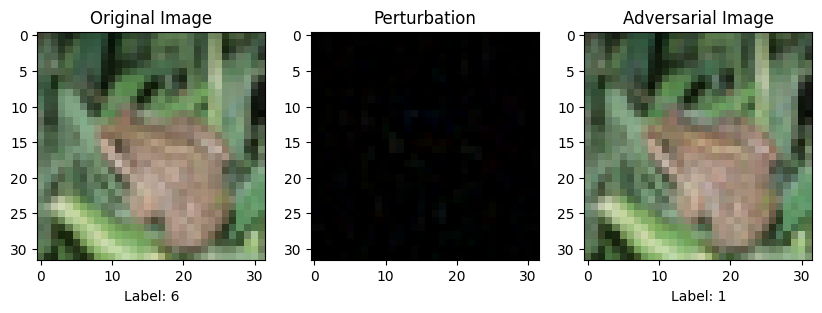

In [31]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## DeepFool attack

In [32]:
# generate the adversarial image using deepfool attack
df_config = AttackConfigs.DeepFoolAttackConfig()
df = DeepFool(df_config)
adversarial_image = df.attack(model, image, label)

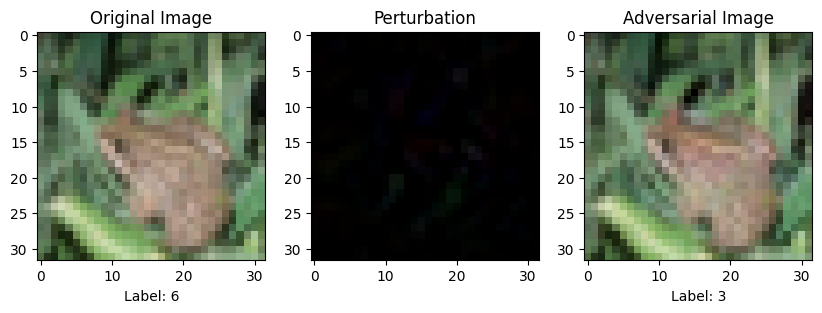

In [33]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## FGSM attack

In [34]:
# generate the adversarial image using FGSM attack
fgsm_config = AttackConfigs.FgsmAttackConfig(
    epsilon=0.05
)
fgsm = FGSM(fgsm_config)
adversarial_image = fgsm.attack(model, image, label)

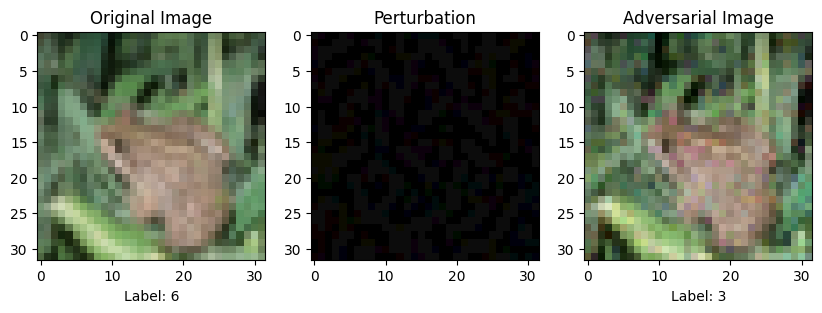

In [35]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## PGD attack

In [36]:
# generate the adversarial image using PGD attack

pgd_config = AttackConfigs.PgdAttackConfig(epsilon=0.05)
pgd = PGD(pgd_config)
adversarial_image = pgd.attack(model, image, label)

PGD Iterations: 100%|██████████| 40/40 [00:00<00:00, 64.66it/s]


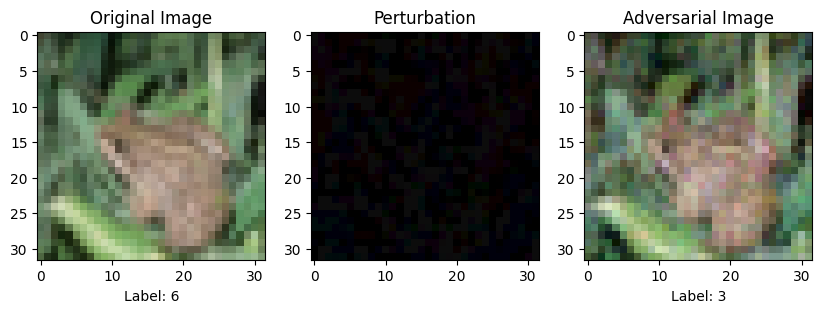

In [37]:
# plot the images
visualize_adversarial_attack(image, label, model, adversarial_image)

## LOTS attack

### Iterative LOTS attack

In [38]:
# generate the adversarial image using LOTS attack
target_layer = "model.fc" # this is the name of the layer that we want to target - this assumes that the model has a layer named fc
lots_config = AttackConfigs.LotsAttackConfig(
    deep_feature_layer=target_layer,
    mode = AttackConfigs.LotsAttackMode.ITERATIVE,
    max_iterations=100,
    learning_rate=0.01,
    epsilon=0.5,
)
lots = LOTS(lots_config)

target_img, target_label = get_img_label(testDataLoader, 10) # get the 10th image from the test dataset
print("Actual label: {}".format(label.item()), " Target label: {}".format(target_label.item()))

adv_img, is_found = lots.attack(model, image, target_img, target_label)
print("Is the adversarial image found: {}".format(is_found))

Actual label: 6  Target label: 0


                                                              0 [00:00<00:02, 32.05it/s]

Is the adversarial image found: True


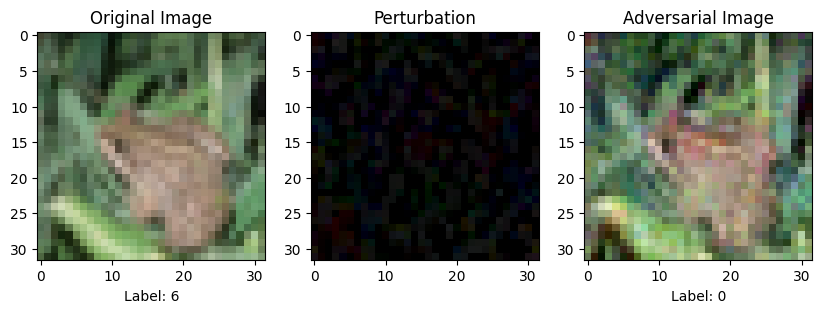

In [39]:
# plot the images
visualize_adversarial_attack(image, label, model, adv_img)

### Single LOTS attack

In [40]:
# generate the adversarial image using LOTS attack
target_layer = "model.fc" # this is the name of the layer that we want to target - this assumes that the model has a layer named fc
lots_config = AttackConfigs.LotsAttackConfig(
    deep_feature_layer=target_layer,
    mode = AttackConfigs.LotsAttackMode.ITERATIVE,
    max_iterations=100,
    learning_rate=0.01,
    epsilon=0.5,
)
lots = LOTS(lots_config)

target_img, target_label = get_img_label(testDataLoader, 10) # get the 10th image from the test dataset
print("Actual label: {}".format(label.item()), " Target label: {}".format(target_label.item()))

adv_img, is_found = lots.attack(model, image, target_img, target_label)
print("Is the adversarial image found: {}".format(is_found))

Actual label: 6  Target label: 0


                                                              0 [00:00<00:03, 22.77it/s]

Is the adversarial image found: True


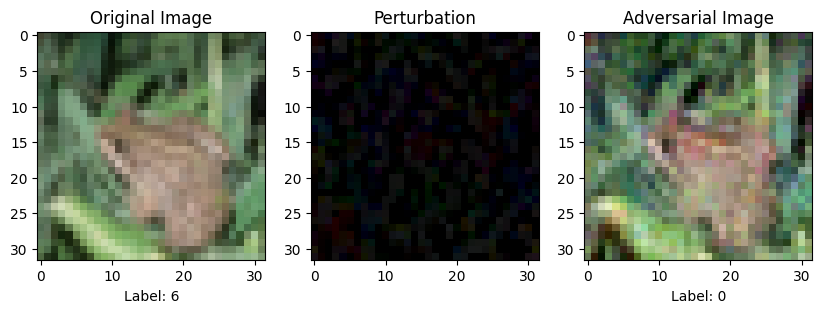

In [41]:
# plot the images
visualize_adversarial_attack(image, label, model, adv_img)